# Step 1 : Setup & Installation

We'll start by installing the special libraries we need: segmentation-models-pytorch for the pre-trained U-Net model and albumentations for data augmentation.

In [1]:
!pip install segmentation-models-pytorch 
!pip install patchify

# Step 2 : Import Libraries & Define Constants

We import all the packages we'll use and define our key constants. This keeps the code clean and makes it easy to change parameters like BATCH_SIZE or NUM_EPOCHS later.

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm

# --- 1. Define Core Constants ---
BASE_DIR = '/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. Define Training Parameters ---
# We use a subset for a fast 8-hour sprint
TOTAL_IMAGES = 2400 
TRAIN_SIZE = 2000
VAL_SIZE = 400

# Training hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 30  # You increased this to 30 for a better score
LEARNING_RATE = 1e-4

# --- 3. Define Paths ---
RED_DIR = os.path.join(BASE_DIR, 'train_red')
GREEN_DIR = os.path.join(BASE_DIR, 'train_green')
BLUE_DIR = os.path.join(BASE_DIR, 'train_blue')
NIR_DIR = os.path.join(BASE_DIR, 'train_nir')
GT_DIR = os.path.join(BASE_DIR, 'train_gt')

print(f"Using device: {DEVICE}")
print(f"Base data directory: {BASE_DIR}")

Using device: cuda
Base data directory: /kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training


#  Step 3: Exploratory Data Analysis (EDA)

Before we build a model, we must understand our data. We'll check the file counts and then load and visualize one sample (an image and its corresponding mask) to confirm everything is correct.

### 3.1. Verify File Counts

This cell checks the train_red and train_gt (ground truth) folders to ensure we have a matching number of images and masks.

In [4]:
# Let's check the contents of our training folders
red_files = os.listdir(os.path.join(BASE_DIR, 'train_red'))
gt_files = os.listdir(os.path.join(BASE_DIR, 'train_gt'))

print(f"Found {len(red_files)} Red channel images.")
print(f"Found {len(gt_files)} Ground Truth masks.")
print("\nFirst 5 red files:")
print(red_files[:5])
print("\nFirst 5 mask files:")
print(gt_files[:5])

Found 8400 Red channel images.
Found 8400 Ground Truth masks.

First 5 red files:
['red_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF', 'red_patch_48_3_by_6_LC08_L1TP_011247_20160620_20170323_01_T1.TIF', 'red_patch_206_11_by_6_LC08_L1TP_002054_20160520_20170324_01_T1.TIF', 'red_patch_397_17_by_13_LC08_L1TP_011002_20160620_20170323_01_T1.TIF', 'red_patch_161_8_by_7_LC08_L1TP_066017_20160520_20170223_01_T1.TIF']

First 5 mask files:
['gt_patch_201_10_by_12_LC08_L1TP_047023_20160920_20170221_01_T1.TIF', 'gt_patch_70_4_by_7_LC08_L1TP_011247_20160620_20170323_01_T1.TIF', 'gt_patch_301_15_by_7_LC08_L1TP_034034_20160520_20170223_01_T1.TIF', 'gt_patch_15_1_by_15_LC08_L1TP_035034_20160120_20170224_01_T1.TIF', 'gt_patch_90_4_by_21_LC08_L1TP_044010_20160220_20170224_01_T1.TIF']


### 3.2. Visualize a Sample

Here, we load all channels for one sample image. We stack the Red, Green, and Blue channels to create a color "RGB" image and plot it next to its black-and-white ground truth mask.

--- EDA for file: red_patch_100_5_by_16_LC08_L1TP_047023_20160920_20170221_01_T1.TIF ---
Image shape: (384, 384, 3)
Mask shape: (384, 384)
Mask values: [  0 255]


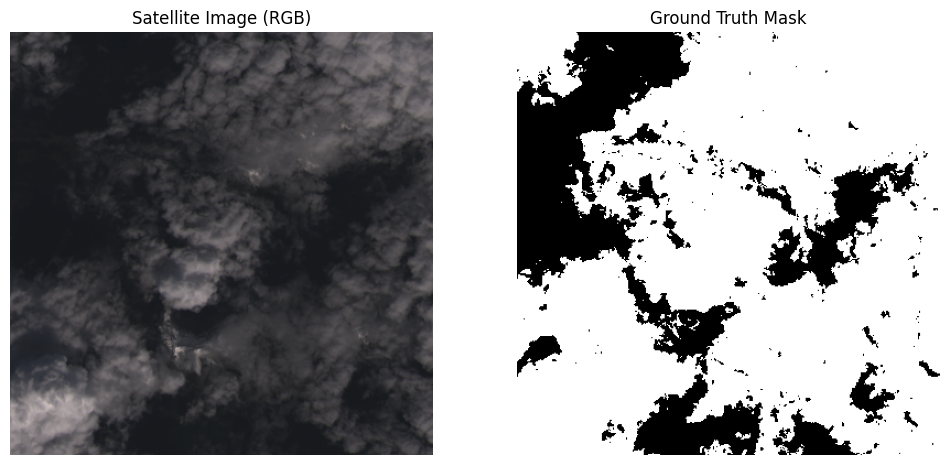

In [5]:
# --- 1. Get a Master List of Files ---
red_files = sorted(os.listdir(RED_DIR))

# --- 2. Load a Sample (e.g., the 10th image) ---
example_red_filename = red_files[10] 

# Construct the paths for all corresponding files
red_path = os.path.join(RED_DIR, example_red_filename)
green_path = os.path.join(GREEN_DIR, example_red_filename.replace('red_', 'green_'))
blue_path = os.path.join(BLUE_DIR, example_red_filename.replace('red_', 'blue_'))
gt_path = os.path.join(GT_DIR, example_red_filename.replace('red_', 'gt_'))

# Open the images
red_img = np.array(Image.open(red_path))
green_img = np.array(Image.open(green_path))
blue_img = np.array(Image.open(blue_path))
gt_mask = np.array(Image.open(gt_path))

# --- 3. Prepare for Plotting ---
# Helper function to normalize 16-bit images (0-65535) to 8-bit (0-255) for plotting
def normalize_for_plot(array):
    return (array / 65535.0 * 255.0).astype(np.uint8)

rgb_img = np.stack([
    normalize_for_plot(red_img),
    normalize_for_plot(green_img),
    normalize_for_plot(blue_img)
], axis=-1)

# Convert mask from 0/255 to 0/1 for plotting
gt_mask_binary = np.where(gt_mask == 255, 1, 0)

# --- 4. Plot the Results ---
print(f"--- EDA for file: {example_red_filename} ---")
print(f"Image shape: {rgb_img.shape}")
print(f"Mask shape: {gt_mask_binary.shape}")
print(f"Mask values: {np.unique(gt_mask)}") # Should be [0 255]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(rgb_img)
ax[0].set_title("Satellite Image (RGB)")
ax[0].axis('off')

ax[1].imshow(gt_mask_binary, cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

plt.show()

# Step 4: Data Preparation Pipeline

This is the most critical part. We define a custom PyTorch Dataset to load our 4-channel images and prepare the data for the model.

### 4.1. Define the CloudDataset Class

This class tells PyTorch how to load one item. It:

1. Takes a filename.
2. Loads all 4 channels (R, G, B, NIR) and the mask.
3. Normalizes values to [0, 1] and casts to float32.
4. Stacks the 4 channels into a single 4D tensor.
5. Applies augmentations (if any).

In [7]:
class CloudDataset(Dataset):
    def __init__(self, base_dir, file_list, transform=None):
        self.base_dir = base_dir
        self.file_list = file_list
        self.transform = transform
        
        # Define directories
        self.red_dir = os.path.join(base_dir, 'train_red')
        self.green_dir = os.path.join(base_dir, 'train_green')
        self.blue_dir = os.path.join(base_dir, 'train_blue')
        self.nir_dir = os.path.join(base_dir, 'train_nir')
        self.gt_dir = os.path.join(base_dir, 'train_gt')

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get the master filename (red)
        red_filename = self.file_list[idx]
        
        # Construct all corresponding file paths
        red_path = os.path.join(self.red_dir, red_filename)
        green_path = os.path.join(self.green_dir, red_filename.replace('red_', 'green_'))
        blue_path = os.path.join(self.blue_dir, red_filename.replace('red_', 'blue_'))
        nir_path = os.path.join(self.nir_dir, red_filename.replace('red_', 'nir_'))
        gt_path = os.path.join(self.gt_dir, red_filename.replace('red_', 'gt_'))
        
        # Load all images
        # We divide by 65535.0 (16-bit) and cast to float32
        red_img = (np.array(Image.open(red_path)) / 65535.0).astype(np.float32)
        green_img = (np.array(Image.open(green_path)) / 65535.0).astype(np.float32)
        blue_img = (np.array(Image.open(blue_path)) / 65535.0).astype(np.float32)
        nir_img = (np.array(Image.open(nir_path)) / 65535.0).astype(np.float32)
        
        # Load mask
        # We divide by 255.0 and cast to float32
        mask = (np.array(Image.open(gt_path)) / 255.0).astype(np.float32)
        
        # Stack the 4 channels (R, G, B, NIR)
        # Shape becomes (384, 384, 4)
        image = np.stack([red_img, green_img, blue_img, nir_img], axis=-1)
        
        # Apply augmentations if any
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # Add a channel dimension to the mask (for the loss function)
        # Shape becomes (1, 384, 384)
        mask = mask.unsqueeze(0)
            
        return image, mask

### 4.2. Define Augmentations & Split Data

We create a simple augmentation pipeline (flipping the image) and then split our file list into training and validation sets.

In [8]:
# Define simple transforms: flip vertically, flip horizontally, and convert to Tensor
transform = A.Compose([
    A.HorizontalFlip(p=0.5), # Simple augmentation
    A.VerticalFlip(p=0.5),   # Simple augmentation
    ToTensorV2() # Converts to (C, H, W) tensor
])

# Get the master file list, shuffle it, and take our subset
all_files = sorted(os.listdir(os.path.join(BASE_DIR, 'train_red')))
np.random.shuffle(all_files)
subset_files = all_files[:TOTAL_IMAGES]

# Split the subset
train_files, val_files = random_split(subset_files, [TRAIN_SIZE, VAL_SIZE])

# Create Dataset instances
train_dataset = CloudDataset(BASE_DIR, list(train_files), transform=transform)
val_dataset = CloudDataset(BASE_DIR, list(val_files), transform=transform)

print(f"Total images in subset: {TOTAL_IMAGES}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Total images in subset: 2400
Training images: 2000
Validation images: 400


### 4.3. Create DataLoaders

The DataLoader batches the data and sends it to the GPU, making training possible.

In [9]:
# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"--- Data Pipeline Ready ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

--- Data Pipeline Ready ---
Number of training batches: 125
Number of validation batches: 25


# Step 5: Define the Model

Now we define our model architecture. We use a pre-trained U-Net from segmentation-models-pytorch, which is the core of our "Transfer Learning" approach.

### 5.1. Instantiate Model, Loss, and Optimizer

We specify our 4-channel input and 1-channel output. We use Dice Loss (perfect for segmentation) and the Adam optimizer.

In [10]:
# Load a pre-trained U-Net with a fast 'resnet34' backbone
model = smp.Unet(
    encoder_name="resnet34",        # Fast and effective
    encoder_weights="imagenet",     # Use pre-trained weights
    in_channels=4,                  # <-- OUR CRITICAL CHANGE! (R,G,B,NIR)
    classes=1,                      # Output is 1 channel (cloud/no cloud)
    activation="sigmoid"            # Sigmoid for 0-1 probability output
)

# Move model to GPU
model.to(DEVICE)

# Define Loss Function and Optimizer
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model, Loss Function, and Optimizer defined.")

Model, Loss Function, and Optimizer defined.


### 5.2. Test the Pipeline

This is a crucial sanity check. We try to load one batch of data and pass it through the model. If this cell runs without errors, we are ready to train.

In [11]:
print("\n--- Testing one batch ---")
try:
    images, masks = next(iter(train_loader))
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    
    print(f"Image batch shape: {images.shape}") # Should be [BATCH_SIZE, 4, 384, 384]
    print(f"Mask batch shape: {masks.shape}")   # Should be [BATCH_SIZE, 1, 384, 384]
    
    # Check data types
    print(f"Image data type: {images.dtype}") # Should be torch.float32
    print(f"Mask data type: {masks.dtype}")   # Should be torch.float32

    # Pass through model
    outputs = model(images)
    print(f"Model output shape: {outputs.shape}") 
    
    # Calculate loss
    loss = loss_fn(outputs, masks)
    print(f"Test batch loss: {loss.item()}")
    print("--- Model and Data Pipeline Test SUCCESSFUL ---")

except Exception as e:
    print(f"--- ERROR in pipeline test ---")
    print(e)


--- Testing one batch ---
Image batch shape: torch.Size([16, 4, 384, 384])
Mask batch shape: torch.Size([16, 1, 384, 384])
Image data type: torch.float32
Mask data type: torch.float32
Model output shape: torch.Size([16, 1, 384, 384])
Test batch loss: 0.5756536722183228
--- Model and Data Pipeline Test SUCCESSFUL ---


# Step 6: Train the Model

We loop for NUM_EPOCHS, training the model on the training data and evaluating it on the validation data. We save the model weights (best_model.pth) only when it achieves a new best validation score.

In [12]:
# Helper function to calculate Dice Score (our metric)
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)
    
    intersection = (preds * targets).sum()
    total = preds.sum() + targets.sum()
    
    dice = (2. * intersection + smooth) / (total + smooth)
    return dice

# --- Training Loop ---
best_val_score = 0.0
model_path = "best_model.pth"

print("\n--- Starting Model Training ---")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1:02}/{NUM_EPOCHS} [Train]")
    
    for images, masks in train_progress_bar:
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # --- Validation Phase ---
    model.eval()
    val_score = 0.0
    
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1:02}/{NUM_EPOCHS} [Val]")
        for images, masks in val_progress_bar:
            images = images.to(DEVICE, dtype=torch.float32)
            masks = masks.to(DEVICE, dtype=torch.float32)
            
            outputs = model(images)
            preds_binary = (outputs > 0.5).float()
            val_score += dice_score(preds_binary, masks)
            val_progress_bar.set_postfix({'val_score': (val_score / len(val_loader)).item()})

    avg_val_score = val_score / len(val_loader)
    
    end_time = time.time()
    epoch_mins = (end_time - start_time) / 60
    
    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins:.2f}m")
    print(f"\tTrain Loss: {avg_train_loss:.4f}")
    print(f"\t Val. Score (Dice): {avg_val_score:.4f}")

    # --- Save the Best Model ---
    if avg_val_score > best_val_score:
        best_val_score = avg_val_score
        torch.save(model.state_dict(), model_path)
        print(f"\t*** New best model saved to {model_path} (Score: {best_val_score:.4f}) ***")

print("--- Training Complete ---")
print(f"Best validation Dice score: {best_val_score:.4f}")
print(f"Model saved to {model_path}")


--- Starting Model Training ---


Epoch 01/30 [Val]: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s, val_score=0.853]


Epoch: 01 | Time: 1.15m
	Train Loss: 0.5515
	 Val. Score (Dice): 0.8532
	*** New best model saved to best_model.pth (Score: 0.8532) ***


Epoch 02/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.23it/s, val_score=0.912]


Epoch: 02 | Time: 1.13m
	Train Loss: 0.5354
	 Val. Score (Dice): 0.9121
	*** New best model saved to best_model.pth (Score: 0.9121) ***


Epoch 03/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.34it/s, val_score=0.916]


Epoch: 03 | Time: 1.15m
	Train Loss: 0.5288
	 Val. Score (Dice): 0.9160
	*** New best model saved to best_model.pth (Score: 0.9160) ***


Epoch 04/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s, val_score=0.931]


Epoch: 04 | Time: 1.15m
	Train Loss: 0.5227
	 Val. Score (Dice): 0.9308
	*** New best model saved to best_model.pth (Score: 0.9308) ***


Epoch 05/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.38it/s, val_score=0.922]


Epoch: 05 | Time: 1.15m
	Train Loss: 0.5232
	 Val. Score (Dice): 0.9224


Epoch 06/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, val_score=0.935]


Epoch: 06 | Time: 1.16m
	Train Loss: 0.5212
	 Val. Score (Dice): 0.9352
	*** New best model saved to best_model.pth (Score: 0.9352) ***


Epoch 07/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, val_score=0.919]


Epoch: 07 | Time: 1.16m
	Train Loss: 0.5200
	 Val. Score (Dice): 0.9192


Epoch 08/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, val_score=0.941]


Epoch: 08 | Time: 1.15m
	Train Loss: 0.5212
	 Val. Score (Dice): 0.9411
	*** New best model saved to best_model.pth (Score: 0.9411) ***


Epoch 09/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.41it/s, val_score=0.939]


Epoch: 09 | Time: 1.16m
	Train Loss: 0.5210
	 Val. Score (Dice): 0.9390


Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s, val_score=0.931]


Epoch: 10 | Time: 1.15m
	Train Loss: 0.5212
	 Val. Score (Dice): 0.9308


Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, val_score=0.912]


Epoch: 11 | Time: 1.15m
	Train Loss: 0.5179
	 Val. Score (Dice): 0.9118


Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, val_score=0.945]


Epoch: 12 | Time: 1.15m
	Train Loss: 0.5185
	 Val. Score (Dice): 0.9452
	*** New best model saved to best_model.pth (Score: 0.9452) ***


Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, val_score=0.947]


Epoch: 13 | Time: 1.16m
	Train Loss: 0.5180
	 Val. Score (Dice): 0.9468
	*** New best model saved to best_model.pth (Score: 0.9468) ***


Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s, val_score=0.949]


Epoch: 14 | Time: 1.15m
	Train Loss: 0.5181
	 Val. Score (Dice): 0.9485
	*** New best model saved to best_model.pth (Score: 0.9485) ***


Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s, val_score=0.943]


Epoch: 15 | Time: 1.15m
	Train Loss: 0.5176
	 Val. Score (Dice): 0.9428


Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, val_score=0.938]


Epoch: 16 | Time: 1.16m
	Train Loss: 0.5200
	 Val. Score (Dice): 0.9382


Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.38it/s, val_score=0.945]


Epoch: 17 | Time: 1.15m
	Train Loss: 0.5239
	 Val. Score (Dice): 0.9447


Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s, val_score=0.94] 


Epoch: 18 | Time: 1.15m
	Train Loss: 0.5177
	 Val. Score (Dice): 0.9399


Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, val_score=0.933]


Epoch: 19 | Time: 1.16m
	Train Loss: 0.5219
	 Val. Score (Dice): 0.9334


Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s, val_score=0.927]


Epoch: 20 | Time: 1.15m
	Train Loss: 0.5173
	 Val. Score (Dice): 0.9270


Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.21it/s, val_score=0.95] 


Epoch: 21 | Time: 1.16m
	Train Loss: 0.5174
	 Val. Score (Dice): 0.9503
	*** New best model saved to best_model.pth (Score: 0.9503) ***


Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.15it/s, val_score=0.941]


Epoch: 22 | Time: 1.16m
	Train Loss: 0.5205
	 Val. Score (Dice): 0.9409


Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.13it/s, val_score=0.911]


Epoch: 23 | Time: 1.16m
	Train Loss: 0.5170
	 Val. Score (Dice): 0.9109


Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s, val_score=0.928]


Epoch: 24 | Time: 1.16m
	Train Loss: 0.5197
	 Val. Score (Dice): 0.9284


Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.19it/s, val_score=0.942]


Epoch: 25 | Time: 1.16m
	Train Loss: 0.5188
	 Val. Score (Dice): 0.9419


Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.22it/s, val_score=0.945]


Epoch: 26 | Time: 1.15m
	Train Loss: 0.5179
	 Val. Score (Dice): 0.9448


Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s, val_score=0.946]


Epoch: 27 | Time: 1.16m
	Train Loss: 0.5171
	 Val. Score (Dice): 0.9459


Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.39it/s, val_score=0.952]


Epoch: 28 | Time: 1.16m
	Train Loss: 0.5202
	 Val. Score (Dice): 0.9523
	*** New best model saved to best_model.pth (Score: 0.9523) ***


Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s, val_score=0.949]


Epoch: 29 | Time: 1.15m
	Train Loss: 0.5202
	 Val. Score (Dice): 0.9492


Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s, val_score=0.945]


Epoch: 30 | Time: 1.15m
	Train Loss: 0.5153
	 Val. Score (Dice): 0.9449
--- Training Complete ---
Best validation Dice score: 0.9523
Model saved to best_model.pth


# Step 7: Evaluate Model Performance

With the model trained, we'll perform our final evaluation. We'll first visualize our model's predictions and then calculate the final, reportable metrics (F1-Score and IoU).

### 7.1. Visualize Predictions

We load our best_model.pth and plot its predictions on 5 validation images side-by-side with the original image and the ground truth.

Model best_model.pth loaded successfully and set to eval mode.

--- Generating Visual Results ---


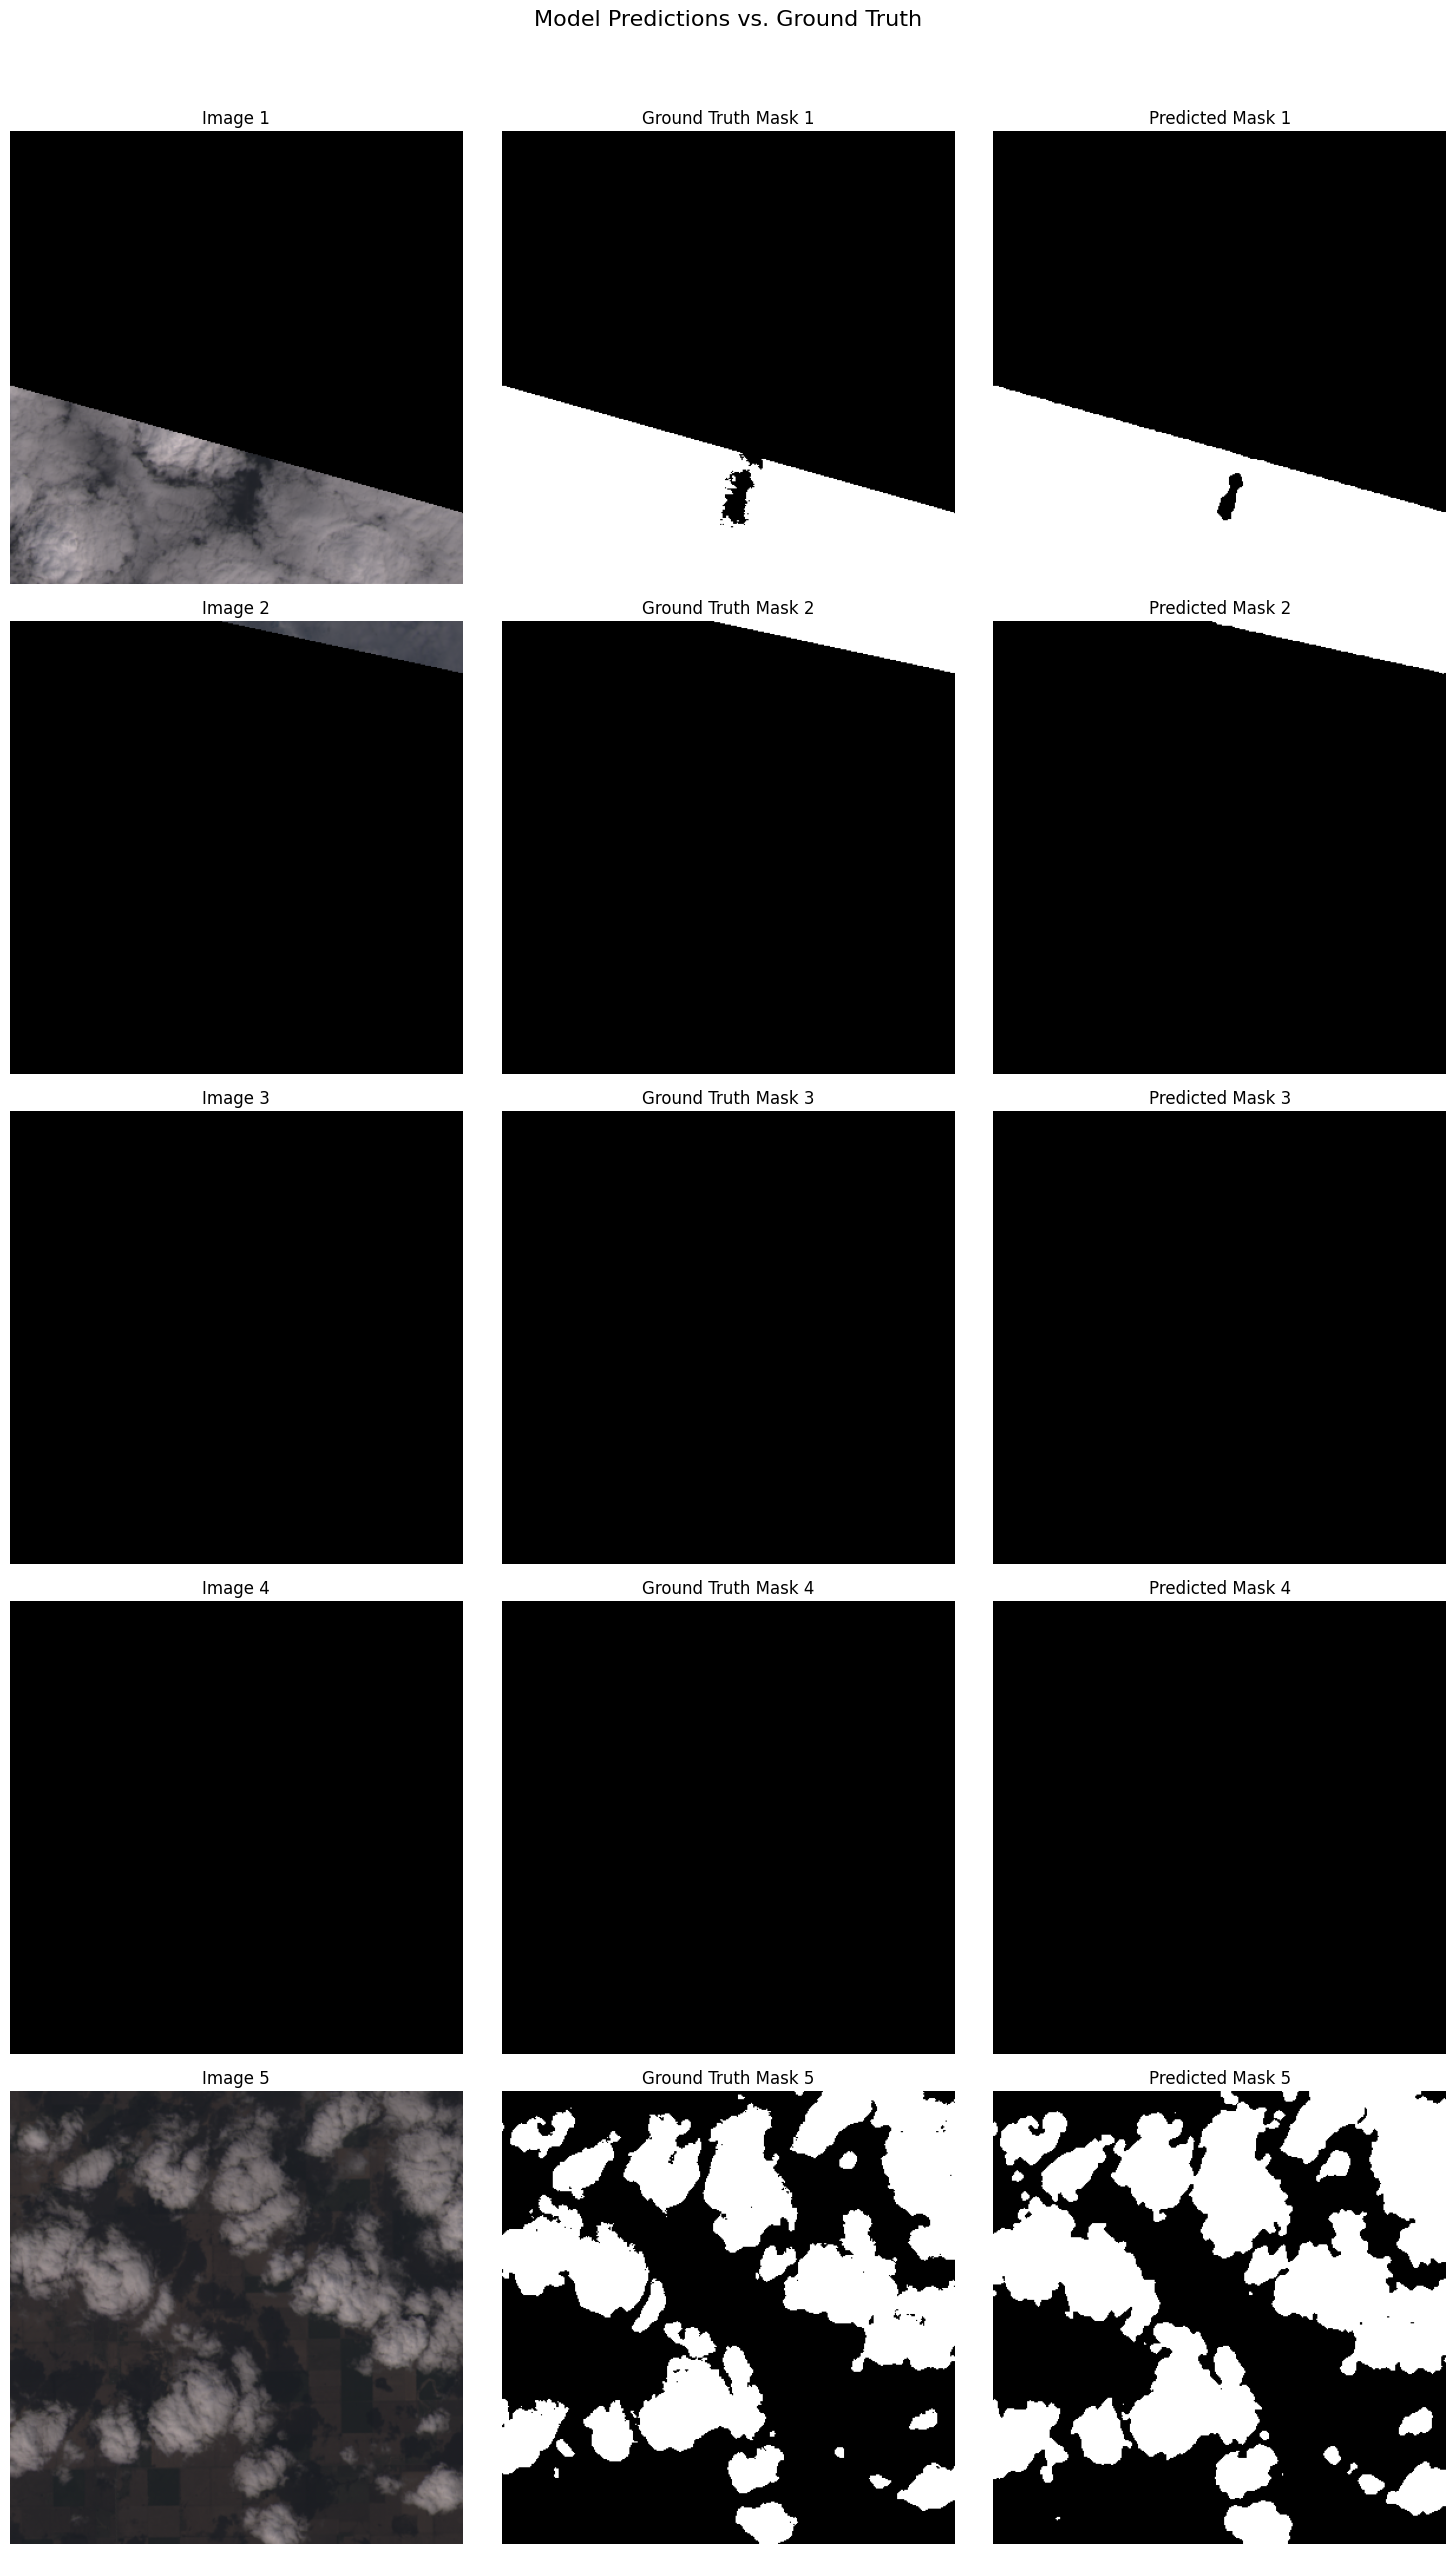

In [13]:
# --- 1. Load the Best Model ---
# We define the architecture again and load the saved weights
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None, # Not needed, we are loading our own weights
    in_channels=4,
    classes=1,
    activation="sigmoid"
)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval() # Set to evaluation mode!

print(f"Model {model_path} loaded successfully and set to eval mode.")

# --- 2. Get a Batch of Validation Data ---
images, masks = next(iter(val_loader))
images = images.to(DEVICE, dtype=torch.float32)

# --- 3. Get Predictions ---
with torch.no_grad():
    preds = model(images)

# --- 4. Move Data to CPU for Plotting ---
num_to_plot = 5
images_np = images.cpu().numpy()[:num_to_plot]
masks_np = masks.cpu().numpy()[:num_to_plot]
preds_np = preds.cpu().numpy()[:num_to_plot]

# Apply 0.5 threshold to predictions to make them binary (0 or 1)
preds_np_binary = (preds_np > 0.5).astype(float)

# --- 5. Plot the Results ---
print("\n--- Generating Visual Results ---")

fig, axes = plt.subplots(num_to_plot, 3, figsize=(15, num_to_plot * 5))
fig.suptitle("Model Predictions vs. Ground Truth", fontsize=16, y=1.02)

for i in range(num_to_plot):
    # --- Prepare Original Image (Column 1) ---
    # We plot R,G,B (channels 0, 1, 2)
    rgb_img = images_np[i, :3, :, :] 
    rgb_img = np.transpose(rgb_img, (1, 2, 0)) # (C, H, W) -> (H, W, C)
    rgb_img = np.clip(rgb_img, 0, 1)

    # --- Plot Original Image ---
    ax = axes[i, 0]
    ax.imshow(rgb_img)
    ax.set_title(f"Image {i+1}")
    ax.axis('off')
    
    # --- Plot Ground Truth Mask (Column 2) ---
    ax = axes[i, 1]
    ax.imshow(np.squeeze(masks_np[i]), cmap='gray')
    ax.set_title(f"Ground Truth Mask {i+1}")
    ax.axis('off')

    # --- Plot Predicted Mask (Column 3) ---
    ax = axes[i, 2]
    ax.imshow(np.squeeze(preds_np_binary[i]), cmap='gray')
    ax.set_title(f"Predicted Mask {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### 7.2. Calculate Final Metrics (F1-Score & IoU)

Finally, we loop over the entire validation set one last time to get our official F1 (Dice) and IoU (Jaccard) scores for the technical report.

In [14]:
print("--- Starting Final Evaluation ---")

# --- 1. Define Metrics Functions ---
iou_metric = smp.metrics.iou_score
f1_metric = smp.metrics.f1_score
get_stats = smp.metrics.get_stats

# --- 2. Load the Best Model ---
# (Model is already loaded and in eval mode from the previous cell, but we'll
#  re-load it here just in case this cell is run independently)
model.load_state_dict(torch.load("best_model.pth"))
model.to(DEVICE)
model.eval() 

# --- 3. Loop Over Entire Validation Set ---
total_tp = 0
total_fp = 0
total_fn = 0
total_tn = 0

with torch.no_grad(): # Disable gradients
    for images, masks in tqdm(val_loader, desc="Calculating Final Metrics"):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)

        # Get predictions (these are probabilities)
        preds = model(images)
        masks_int = masks.long()
        
        # Get stats (tp, fp, fn, tn) for this batch
        tp, fp, fn, tn = get_stats(preds, masks_int, mode='binary', threshold=0.5)
        
        # Sum the stats across all batches
        total_tp += tp.sum()
        total_fp += fp.sum()
        total_fn += fn.sum()
        total_tn += tn.sum()

# --- 4. Calculate Final Metrics from Total Stats ---
final_f1 = f1_metric(total_tp, total_fp, total_fn, total_tn)
final_iou = iou_metric(total_tp, total_fp, total_fn, total_tn)

print("\n--- Final Performance Evaluation Report ---")
print(f"Metrics calculated on {len(val_dataset)} validation images.")
print(f"\n**Average F1-Score (Dice): {final_f1.item():.4f}**")
print(f"**Average IoU (Jaccard): {final_iou.item():.4f}**")

--- Starting Final Evaluation ---


Calculating Final Metrics: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]



--- Final Performance Evaluation Report ---
Metrics calculated on 400 validation images.

**Average F1-Score (Dice): 0.9566**
**Average IoU (Jaccard): 0.9167**
